# Statistical arbitrage with lead-lag detection

### paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4599565

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [3]:
num_periods = 252 # number of periods to use for calculating metrics (depends on data resolution)

def calculate_metrics(cumret, num_periods=num_periods):
    '''
    calculate performance metrics from cumulative returns
    
    cumret: cumulative returns
    num_periods: number of periods in a year (e.g. 252 if cumret is at daily resolution)
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(num_periods/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(num_periods) * np.nanmean(rets) / np.nanstd(rets)
    sortino = np.sqrt(num_periods) * np.nanmean(rets) / np.nanstd(rets[rets<0])
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, sortino, maxDD, maxDDD

## Calculating $C_1$ metric

$C_1(\tilde{R}_{p,t}, \tilde{R}_{q,t}) = argmax_{l \in [-T,T]} \Big( Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t-l}) \Big)$

##### Formula in the paper (shown above) is not correct, see examples below 

In [4]:
def lagged_corr(x1,x2,l):
    '''
    compute correlation between x1_{t} and x2_{t-l}

    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    l : int
    '''

    if l>0:
        corr = np.corrcoef(x1[l:].T,x2[:-l].T)[0][1] # l positive -> x1 is a follower
    elif l==0:
        corr = np.corrcoef(x1.T,x2.T)[0][1]
    elif l<0:
        corr = np.corrcoef(x1[:l].T,x2[-l:].T)[0][1] # l negative -> x2 is a follower
    
    return corr

def calculate_C1(x1,x2,T):
    '''
    calculate C1 score between x1 and x2 for maxlag T
    
    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    T : int
    '''

    correlations = {l:lagged_corr(x1,x2,l) for l in range(-T,T+1)}
    return max(correlations, key=correlations.get)

#### example 1

In [5]:
# generate data
np.random.seed(1)
x1 = np.random.randn(500) # leader
x2 = 0.5*x1 + 0.1*np.random.randn(len(x1)) # follower
x1 = x1[1:].reshape(-1,1)
x2 = x2[:-1].reshape(-1,1)
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

In [6]:
c1 = calculate_C1(x1,x2,1) # calculate C1
c1

-1

#### In generated sample x1 is a leader, but according to the $C_1$ metric, it is a follower. When $l$ is negative, let's say $l=-1$, we are calculating $Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t+1})$, which is high when the first stock is a leader, not a follower.

#### What we need to do is to calculate $Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t+l})$, when $l$ is positive, and calculate $Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t-l})$, when $l$ is negative. Which results in the following formula.

$C_1(\tilde{R}_{p,t}, \tilde{R}_{q,t}) = argmax_{l \in [-T,T]} \Big( Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t+l}) \Big)$

In [7]:
# fixing the problem

def lagged_corr(x1,x2,l):
    '''
    compute correlation between x1_{t} and x2_{t-l}

    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    l : int
    '''

    if l>0:
        corr = np.corrcoef(x1[:-l].T,x2[l:].T)[0][1]
    elif l==0:
        corr = np.corrcoef(x1.T,x2.T)[0][1]
    elif l<0:
        corr = np.corrcoef(x1[-l:].T,x2[:l].T)[0][1]
    
    return corr

def calculate_C1(x1,x2,T):
    '''
    calculate C1 score between x1 and x2 for maxlag T
    
    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    T : int
    '''

    correlations = {l:lagged_corr(x1,x2,l) for l in range(-T,T+1)}
    return max(correlations, key=correlations.get)

#### repeat example 1

In [8]:
# generate data
np.random.seed(1)
x1 = np.random.randn(500) # leader
x2 = 0.5*x1 + 0.1*np.random.randn(len(x1)) # follower
x1 = x1[1:].reshape(-1,1)
x2 = x2[:-1].reshape(-1,1)
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

In [9]:
c1 = calculate_C1(x1,x2,1) # calculate C1
c1

1

#### Now the metric if correct: $C_1=1$ therefore x1 is a leader

#### Let's look at another example

In [10]:
# generate data
np.random.seed(14)
x1 = np.random.randn(500) # leader
x2 = -0.5*x1 + 0.1*np.random.randn(len(x1)) # follower
x1 = x1[1:].reshape(-1,1)
x2 = x2[:-1].reshape(-1,1)
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

In [11]:
c1 = calculate_C1(x1,x2,1) # calculate C1
c1

-1

#### x1 is still a leader, but the metric is wrong, let's take a look why we get wrong answer.

In [12]:
{l:lagged_corr(x1,x2,l) for l in range(-1,1+1)}

{-1: 0.002248857126154959, 0: -0.048742161175448384, 1: -0.9800099543536932}

#### According to the formula we are selecting the index of the largest correlation. It works fine if the correlation between leader and follower is positive. But when we have negative correlation between leader and follower, the metric is wrong. To fix it we need to change correlation to absolute value of correlation.

$C_1(\tilde{R}_{p,t}, \tilde{R}_{q,t}) = argmax_{l \in [-T,T]} \Big| Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t+l}) \Big|$

In [13]:
# fixing the problem

def lagged_corr(x1,x2,l):
    '''
    compute correlation between x1_{t} and x2_{t-l}

    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    l : int
    '''

    if l>0:
        corr = np.corrcoef(x1[:-l].T,x2[l:].T)[0][1]
    elif l==0:
        corr = np.corrcoef(x1.T,x2.T)[0][1]
    elif l<0:
        corr = np.corrcoef(x1[-l:].T,x2[:l].T)[0][1]
    
    return corr

def calculate_C1(x1,x2,T):
    '''
    calculate C1 score between x1 and x2 for maxlag T
    
    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    T : int
    '''

    correlations = {l:abs(lagged_corr(x1,x2,l)) for l in range(-T,T+1)}
    return max(correlations, key=correlations.get)

In [14]:
# generate data
np.random.seed(14)
x1 = np.random.randn(500) # leader
x2 = 0.5*x1 + 0.1*np.random.randn(len(x1)) # follower
x1 = x1[1:].reshape(-1,1)
x2 = x2[:-1].reshape(-1,1)
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

c1 = calculate_C1(x1,x2,1) # calculate C1
c1

1

In [15]:
# generate data
x1 = np.random.randn(500) # leader
x2 = -0.5*x1 + 0.1*np.random.randn(len(x1)) # follower
x1 = x1[1:].reshape(-1,1)
x2 = x2[:-1].reshape(-1,1)
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

c1 = calculate_C1(x1,x2,1) # calculate C1
c1

1

# Calculating $C_2$ metric

$ C_2(\tilde{R}_{p,t}, \tilde{R}_{q,t}) = \pm \frac{1}{T} \max \Big[ \sum_{l \in [-T,0]} Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t-l}), \sum_{l \in [0,T]} Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t-l}) \Big] $

- First of all, we need to sum the absolute values of the correlations, otherwise the metric will not work as expected if correlations are negative
- Let's change the sign of $l$ in correlations to plus, so that it matches $C_1$

$ C_2(\tilde{R}_{p,t}, \tilde{R}_{q,t}) = \pm \frac{1}{T} \max \Big[ \sum_{l \in [-T,0]} | Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t+l}) |, \sum_{l \in [0,T]} | Corr(\tilde{R}_{p,t}, \tilde{R}_{q,t+l}) | \Big] $

The sign of the metric must change depending on which sum ends up bigger:
- if the first sum is bigger, then $\tilde{R}_p$ is a follower and the metric must be negative
- if the second sum is bigger, then $\tilde{R}_p$ is a leader and the metric must be positive

In [16]:
def calculate_C2(x1,x2,T):
    '''
    calculate C2 score between x1 and x2 for maxlag T
    
    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    T : int
    '''

    corr_nlag = [] # correlations for negative lags
    for l in range(-T,1):
        corr  = lagged_corr(x1,x2,l)
        corr_nlag.append(corr)
    corr_plag = [] # correlations for negative lags
    for l in range(0,T+1):
        corr = lagged_corr(x1,x2,l)
        corr_plag.append(corr)

    sum1 = np.abs(corr_nlag).sum()
    sum2 = np.abs(corr_plag).sum()

    if sum1>sum2:
        c2 = -1/T * sum1
    elif sum2>sum1:
        c2 = 1/T * sum2

    return c2

In [17]:
np.random.seed(1)
x1 = np.random.randn(500) # leader
x2 = 0.5*x1 + 0.1*np.random.randn(len(x1)) # follower
x1 = x1[1:].reshape(-1,1)
x2 = x2[:-1].reshape(-1,1)
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

c2 = calculate_C2(x1,x2,1) # calculate C2
c2

0.9911297158265311

In [18]:
np.random.seed(14)
x1 = np.random.randn(500) # leader
x2 = -0.5*x1 + 0.1*np.random.randn(len(x1)) # follower
x1 = x1[1:].reshape(-1,1)
x2 = x2[:-1].reshape(-1,1)
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

c2 = calculate_C2(x1,x2,1) # calculate C2
c2

1.0287521155291417

# Calculating Levy area

#### Library for computing signatures and Levy area: https://github.com/kormilitzin/the-signature-method-in-machine-learning

#### Primer on signature methods: https://www.researchgate.net/publication/301855102_A_Primer_on_the_Signature_Method_in_Machine_Learning

In [19]:
import esig.tosig as ts

In [24]:
X_1 = np.array([1., 3., 5., 8.]).reshape((-1,1))
X_2 = np.array([1., 4., 2., 6.]).reshape((-1,1))
two_dim_stream = np.append(X_1,X_2, axis=1)
signatures = ts.stream2sig(two_dim_stream, 2)

In [25]:
print(signatures)

[ 1.   7.   5.  24.5 19.  16.  12.5]


#### Signatures are in the following order 

$ (1, S^{(1)}, S^{(2)}, S^{(1,1)}, S^{(1,2)}, S^{(2,1)}, S^{(2,2)}) $ 

#### Formula for Levy area: 

$ A_{i,j}^{Levy} = \frac{1}{2} (S(X)_{s,t}^{i,j} - S(X)_{s,t}^{j,i}) $

In [26]:
# Levy area:
A_12 = 1/2 * (signatures[4] - signatures[5])
A_12

1.5

# Monte Carlo simulation from the paper

In [27]:
levy_areas = []
C1s = []
C2s = []

for i in tqdm(range(50000)):
    # generate data
    np.random.seed(i)
    x1 = np.random.randn(500) # leader
    x2 = 10/(1 + np.exp(-x1)) + 5/(1 + np.exp(10*x1)) - 7.5 # follower
    x1 = x1[1:].reshape(-1,1)
    x2 = x2[:-1].reshape(-1,1)
    x1 = (x1 - x1.mean()) / x1.std() # standardize x1
    x2 = (x2 - x2.mean()) / x2.std() # standardize x2
    two_dim = np.append(x1,x2,axis=1) # combine in one array
    signatures = ts.stream2sig(two_dim,2) # compute signatures
    A_12 = 1/2 * (signatures[4] - signatures[5]) # calculate Levy area
    c1 = calculate_C1(x1,x2,1) # calculate C1
    c2 = calculate_C2(x1,x2,1) # calculate C2
    # save results
    levy_areas.append(A_12) 
    C1s.append(c1)
    C2s.append(c2)

100%|██████████| 50000/50000 [01:06<00:00, 754.51it/s]


In [28]:
levy_areas = np.array(levy_areas)
C1s = np.array(C1s)
C2s = np.array(C2s)

#### Calculate percentages of simulations where a given metric correctly identifies X1 as a leader

In [29]:
len(levy_areas[levy_areas>0]) / len(levy_areas)

0.94298

In [30]:
len(C1s[C1s>0]) / len(C1s)

0.83548

In [31]:
len(C2s[C2s>0]) / len(C2s)

0.89484

# Prepare data

In [32]:
prices = pd.read_csv('../sp500.csv', index_col=0)
prices.index = pd.to_datetime(prices.index)

In [33]:
prices = prices.loc['2021-10-01':'2022-12-31']

In [34]:
prices

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,158.540527,59.007622,112.580101,99.713242,314.541687,57.995205,577.469971,192.961227,21.437044,50.128677,...,233.930954,387.698120,86.530708,58.383678,117.948547,118.597664,510.980011,142.538239,58.647987,192.770309
2021-10-04,157.966248,58.700539,110.966476,99.384178,309.342285,58.338604,558.489990,191.022034,21.380877,49.967697,...,230.513229,386.705200,82.909149,59.701027,116.003799,118.022125,502.320007,139.925339,58.786194,190.313889
2021-10-05,159.617340,61.090019,111.302650,100.097137,314.793457,59.406937,566.700012,194.642471,21.886381,50.592648,...,236.018509,391.572632,84.387543,59.140450,119.086212,118.559288,506.890015,139.238724,58.472919,193.035629
2021-10-06,160.083923,61.176376,111.888542,99.923470,314.861298,59.426006,570.309998,195.817459,21.923826,50.488495,...,234.319336,398.455322,83.593773,60.102768,118.872299,118.616844,506.390015,139.553406,57.864780,192.367447
2021-10-07,159.545547,62.049648,113.252464,101.340240,315.887604,60.112804,578.960022,198.281998,22.551022,51.283886,...,234.484421,405.211456,84.824112,59.766430,118.979256,120.113213,504.410004,140.888504,58.113564,195.541153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,113.290985,55.871151,106.058311,156.766922,261.928528,92.479233,338.450012,235.585587,27.770979,70.109039,...,240.837219,559.257568,80.091263,68.115936,108.321205,126.519447,248.220001,125.714478,46.140095,144.442413
2022-12-27,113.366432,56.627228,106.440659,156.661209,261.160736,93.740044,335.089996,235.673584,27.906540,70.587845,...,241.024475,559.485291,83.673149,68.730545,109.298492,127.500969,251.000000,126.299927,46.511501,143.986588
2022-12-28,111.546455,55.743504,105.715179,155.930695,259.004974,91.501854,328.329987,232.564270,27.422386,69.835449,...,238.225769,551.300720,79.466171,68.235489,107.541344,126.921883,246.839996,125.019859,45.682983,142.529861


In [35]:
returns = prices.pct_change().dropna()

In [36]:
ff_data = pd.read_csv('../F-F_Research_Data_Factors_daily.CSV', skiprows=3, index_col=0).iloc[:-1]
ff_data.index = pd.to_datetime(ff_data.index)
ff_data = ff_data.loc[returns.index]
ff_data /= 100 # percent to decimal

In [37]:
ff_data

,Mkt-RF,SMB,HML,RF
Date,,,,
2021-10-04,-0.0143,-0.0003,0.0233,0.00000
2021-10-05,0.0105,-0.0052,-0.0007,0.00000
2021-10-06,0.0033,-0.0087,-0.0049,0.00000
2021-10-07,0.0101,0.0053,-0.0017,0.00000
2021-10-08,-0.0028,-0.0061,0.0112,0.00000
...,...,...,...,...
2022-12-23,0.0051,-0.0061,0.0116,0.00016
2022-12-27,-0.0051,-0.0074,0.0142,0.00016
2022-12-28,-0.0123,-0.0024,-0.0029,0.00016


In [38]:
ff_data['Mkt-RF']

Date
2021-10-04   -0.0143
2021-10-05    0.0105
2021-10-06    0.0033
2021-10-07    0.0101
2021-10-08   -0.0028
               ...  
2022-12-23    0.0051
2022-12-27   -0.0051
2022-12-28   -0.0123
2022-12-29    0.0187
2022-12-30   -0.0022
Name: Mkt-RF, Length: 314, dtype: float64

In [39]:
returns.loc[:,['Mkt']] = ff_data['Mkt-RF'] + ff_data['RF'] # market return

# Function to calculate lead-lag metrics

In [40]:
def lagged_corr(x1,x2,l):
    '''
    compute correlation between x1_{t} and x2_{t-l}

    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    l : int
    '''

    if l>0:
        corr = np.corrcoef(x1[:-l].T,x2[l:].T)[0][1]
    elif l==0:
        corr = np.corrcoef(x1.T,x2.T)[0][1]
    elif l<0:
        corr = np.corrcoef(x1[-l:].T,x2[:l].T)[0][1]
    
    return corr

def calculate_C1(x1,x2,T):
    '''
    calculate C1 score between x1 and x2 for maxlag T
    
    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    T : int
    '''

    correlations = {l:abs(lagged_corr(x1,x2,l)) for l in range(-T,T+1)}
    return max(correlations, key=correlations.get)

def calculate_C2(x1,x2,T):
    '''
    calculate C2 score between x1 and x2 for maxlag T
    
    x1 : array_like (n_obs * 1)
    x2 : array_like (n_obs * 1)
    T : int
    '''

    corr_nlag = [] # correlations for negative lags
    for l in range(-T,1):
        corr  = lagged_corr(x1,x2,l)
        corr_nlag.append(corr)
    corr_plag = [] # correlations for negative lags
    for l in range(0,T+1):
        corr = lagged_corr(x1,x2,l)
        corr_plag.append(corr)

    sum1 = np.abs(corr_nlag).sum()
    sum2 = np.abs(corr_plag).sum()

    if sum1>sum2:
        c2 = -1/T * sum1
    elif sum2>sum1:
        c2 = 1/T * sum2

    return c2

In [41]:
import esig.tosig as ts # library for calculating signatures for Levy area

# Test portfolios using different metrics

### C1 metric

In [42]:
w = 60 # length of rolling window
maxlag = 1 # number of lags to test
num_leaders = int(len(returns.columns) * 0.2) # 20% leaders
num_followers = int(len(returns.columns) * 0.2) # 20% followers

In [43]:
def backtest_c1(t):
    # prepare data
    returns_tmp = returns.loc[:t].iloc[-w:].dropna(axis=1)
    returns_tmp = returns_tmp.drop('Mkt', axis=1) # remove market returns

    # construct matrix C
    c1_matrix = pd.DataFrame(index=returns_tmp.columns, columns=returns_tmp.columns)
    for s1 in c1_matrix.index:
        for s2 in c1_matrix.columns:
            if s1!=s2 and np.isnan(c1_matrix.loc[s1][s2]):
                c1 = calculate_C1(returns_tmp[s1].values, returns_tmp[s2].values, maxlag)
                c1_matrix.loc[s1][s2] = c1
                c1_matrix.loc[s2][s1] = -c1
    c1_matrix = c1_matrix.astype(float)
    # define leaders and followers
    leaders = c1_matrix.mean(axis=1).sort_values().iloc[-num_leaders:].index
    followers = c1_matrix.mean(axis=1).sort_values().iloc[:num_followers].index

    # construct positions dataframe
    positions = pd.DataFrame(index=returns_tmp.iloc[-1:].index, columns=returns.columns)
    if returns_tmp.loc[t][leaders].mean()>=0:
        positions.loc[t, followers] = 1 # long position in followers
        positions.loc[t, ['Mkt']] = -len(followers) # short position in the market
    else:
        positions.loc[t, followers] = -1 # short position in followers
        positions.loc[t, ['Mkt']] = len(followers) # long position in the market

    return positions, c1_matrix

In [44]:
from concurrent.futures import ProcessPoolExecutor
e = ProcessPoolExecutor()
futures = [e.submit(backtest_c1, t) for t in prices.iloc[w:].index]
positions = pd.concat([f.result()[0] for f in futures])

In [45]:
# make absolute values of long and short positions sum to 1
positions[positions>0] *= 1/abs(positions[positions>0].sum(axis=1)).values.reshape(-1,1)
positions[positions<0] *= 1/abs(positions[positions<0].sum(axis=1)).values.reshape(-1,1)

In [46]:
# calculate strategy returns
ret = (positions.shift() * returns.loc[positions.index]).sum(axis=1)
cumret_c1 = (1 + ret).cumprod()

In [47]:
# calculate market cumulative return
cumret_market = (1 + returns.loc[positions.index, 'Mkt']).cumprod()

In [48]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'Sortino', 'MaxDD', 'MaxDDD'])
results_df.loc['Market'] = calculate_metrics(cumret_market)
results_df.loc['Algo C1'] = calculate_metrics(cumret_c1)

In [49]:
results_df

,Total return,APR,Sharpe,Sortino,MaxDD,MaxDDD
Market,-0.205318,-0.203167,-0.778908,-1.252009,-0.256740,250.0
Algo C1,0.120655,0.119154,1.129044,1.780997,-0.073737,55.0


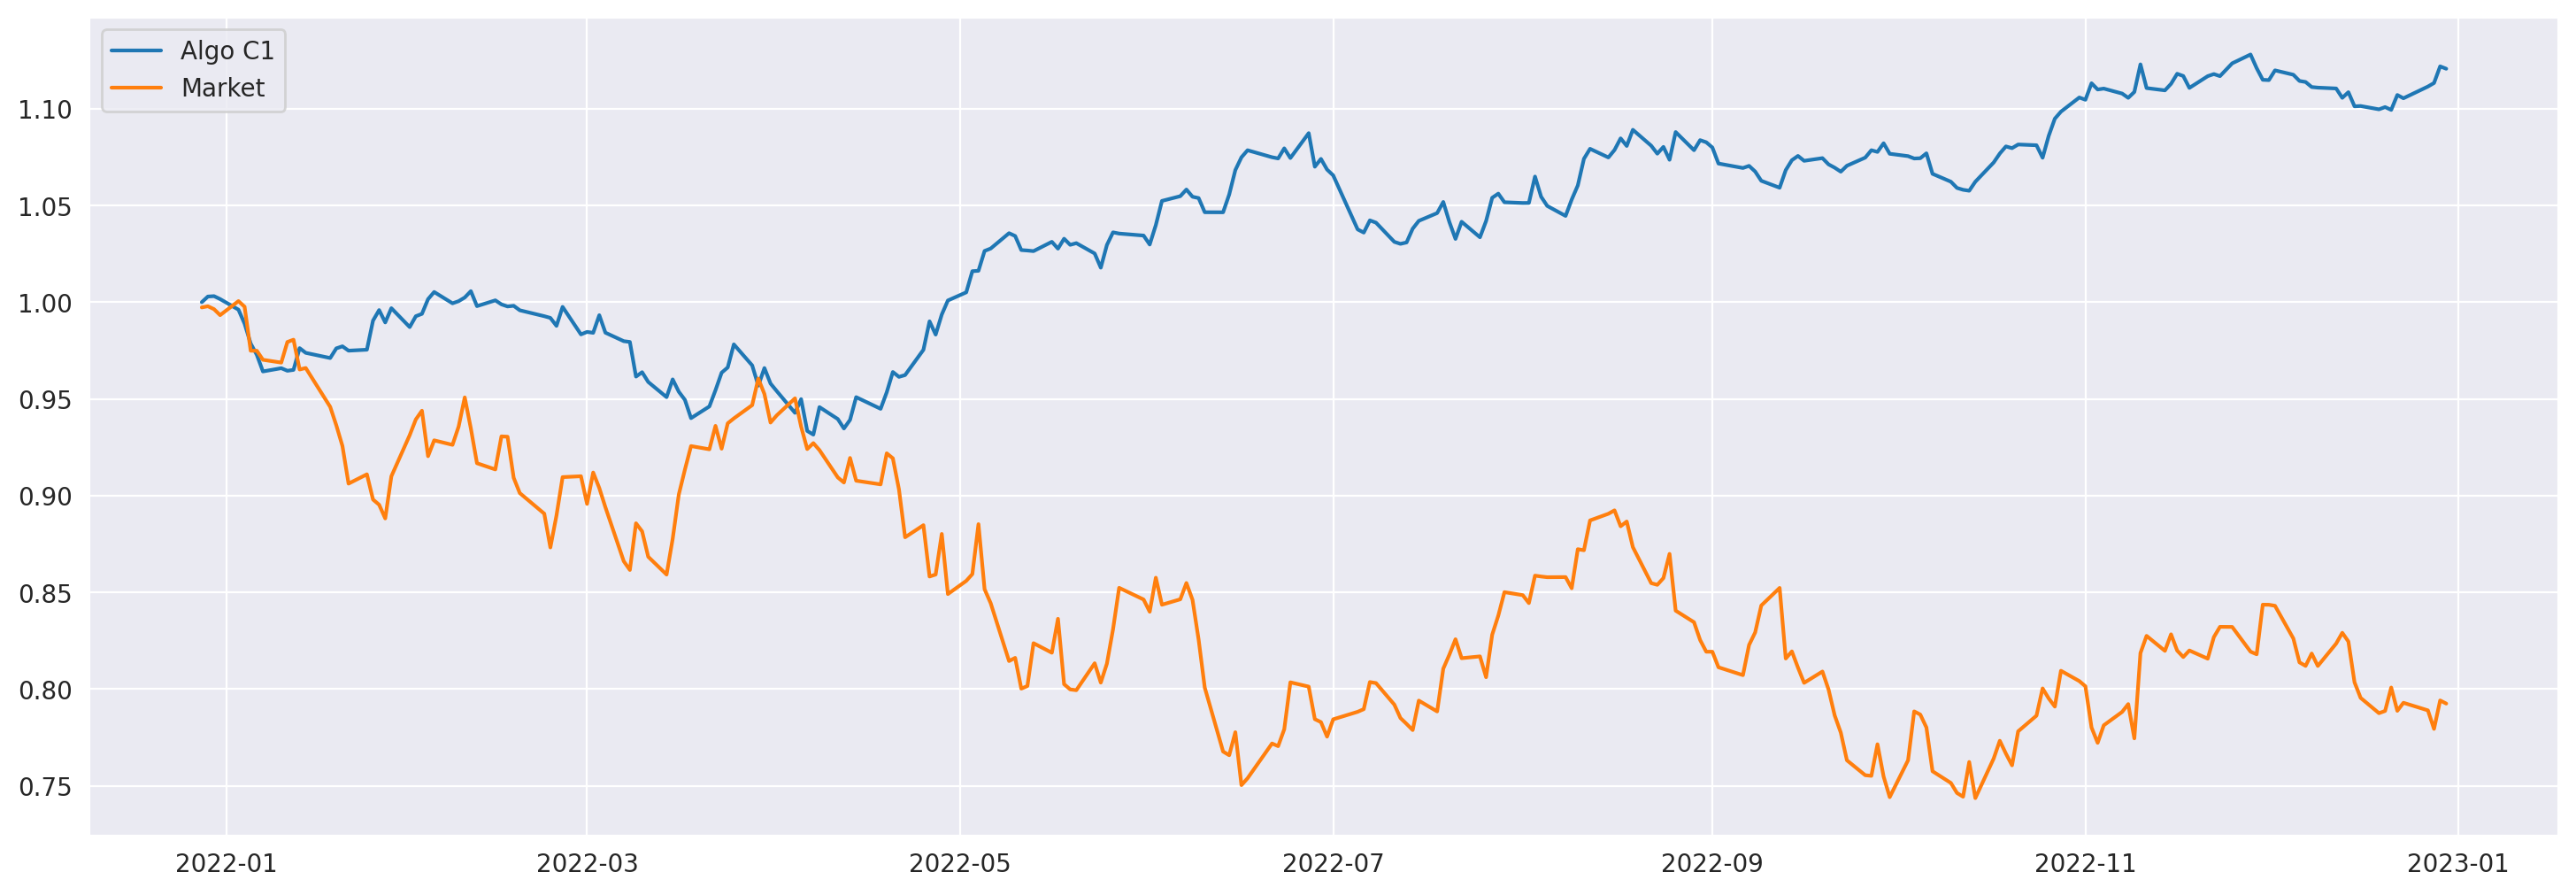

In [50]:
plt.figure(figsize=(18,6))
plt.plot(cumret_c1, label='Algo C1')
plt.plot(cumret_market, label='Market')
plt.legend()

### C2 metric

In [51]:
def backtest_c2(t):
    # prepare data
    returns_tmp = returns.loc[:t].iloc[-w:].dropna(axis=1)
    returns_tmp = returns_tmp.drop('Mkt', axis=1) # remove market returns

    # construct matrix C
    c2_matrix = pd.DataFrame(index=returns_tmp.columns, columns=returns_tmp.columns)
    for s1 in c2_matrix.index:
        for s2 in c2_matrix.columns:
            if s1!=s2 and np.isnan(c2_matrix.loc[s1][s2]):
                c2 = calculate_C2(returns_tmp[s1].values, returns_tmp[s2].values, maxlag)
                c2_matrix.loc[s1][s2] = c2
                c2_matrix.loc[s2][s1] = -c2
    c2_matrix = c2_matrix.astype(float)
    # define leaders and followers
    leaders = c2_matrix.mean(axis=1).sort_values().iloc[-num_leaders:].index
    followers = c2_matrix.mean(axis=1).sort_values().iloc[:num_followers].index

    # construct positions dataframe
    positions = pd.DataFrame(index=returns_tmp.iloc[-1:].index, columns=returns.columns)
    if returns_tmp.loc[t][leaders].mean()>=0:
        positions.loc[t, followers] = 1 # long position in followers
        positions.loc[t, ['Mkt']] = -len(followers) # short position in the market
    else:
        positions.loc[t, followers] = -1 # short position in followers
        positions.loc[t, ['Mkt']] = len(followers) # long position in the market

    return positions, c2_matrix

In [52]:
e = ProcessPoolExecutor()
futures = [e.submit(backtest_c2, t) for t in prices.iloc[w:].index]
positions = pd.concat([f.result()[0] for f in futures])

In [53]:
# make absolute values of long and short positions sum to 1
positions[positions>0] *= 1/abs(positions[positions>0].sum(axis=1)).values.reshape(-1,1)
positions[positions<0] *= 1/abs(positions[positions<0].sum(axis=1)).values.reshape(-1,1)

In [54]:
# calculate strategy returns
ret = (positions.shift() * returns.loc[positions.index]).sum(axis=1)
cumret_c2 = (1 + ret).cumprod()

In [55]:
results_df.loc['Algo C2'] = calculate_metrics(cumret_c2)

In [56]:
results_df

,Total return,APR,Sharpe,Sortino,MaxDD,MaxDDD
Market,-0.205318,-0.203167,-0.778908,-1.252009,-0.256740,250.0
Algo C1,0.120655,0.119154,1.129044,1.780997,-0.073737,55.0
Algo C2,0.038647,0.038184,0.483870,0.796628,-0.072797,164.0


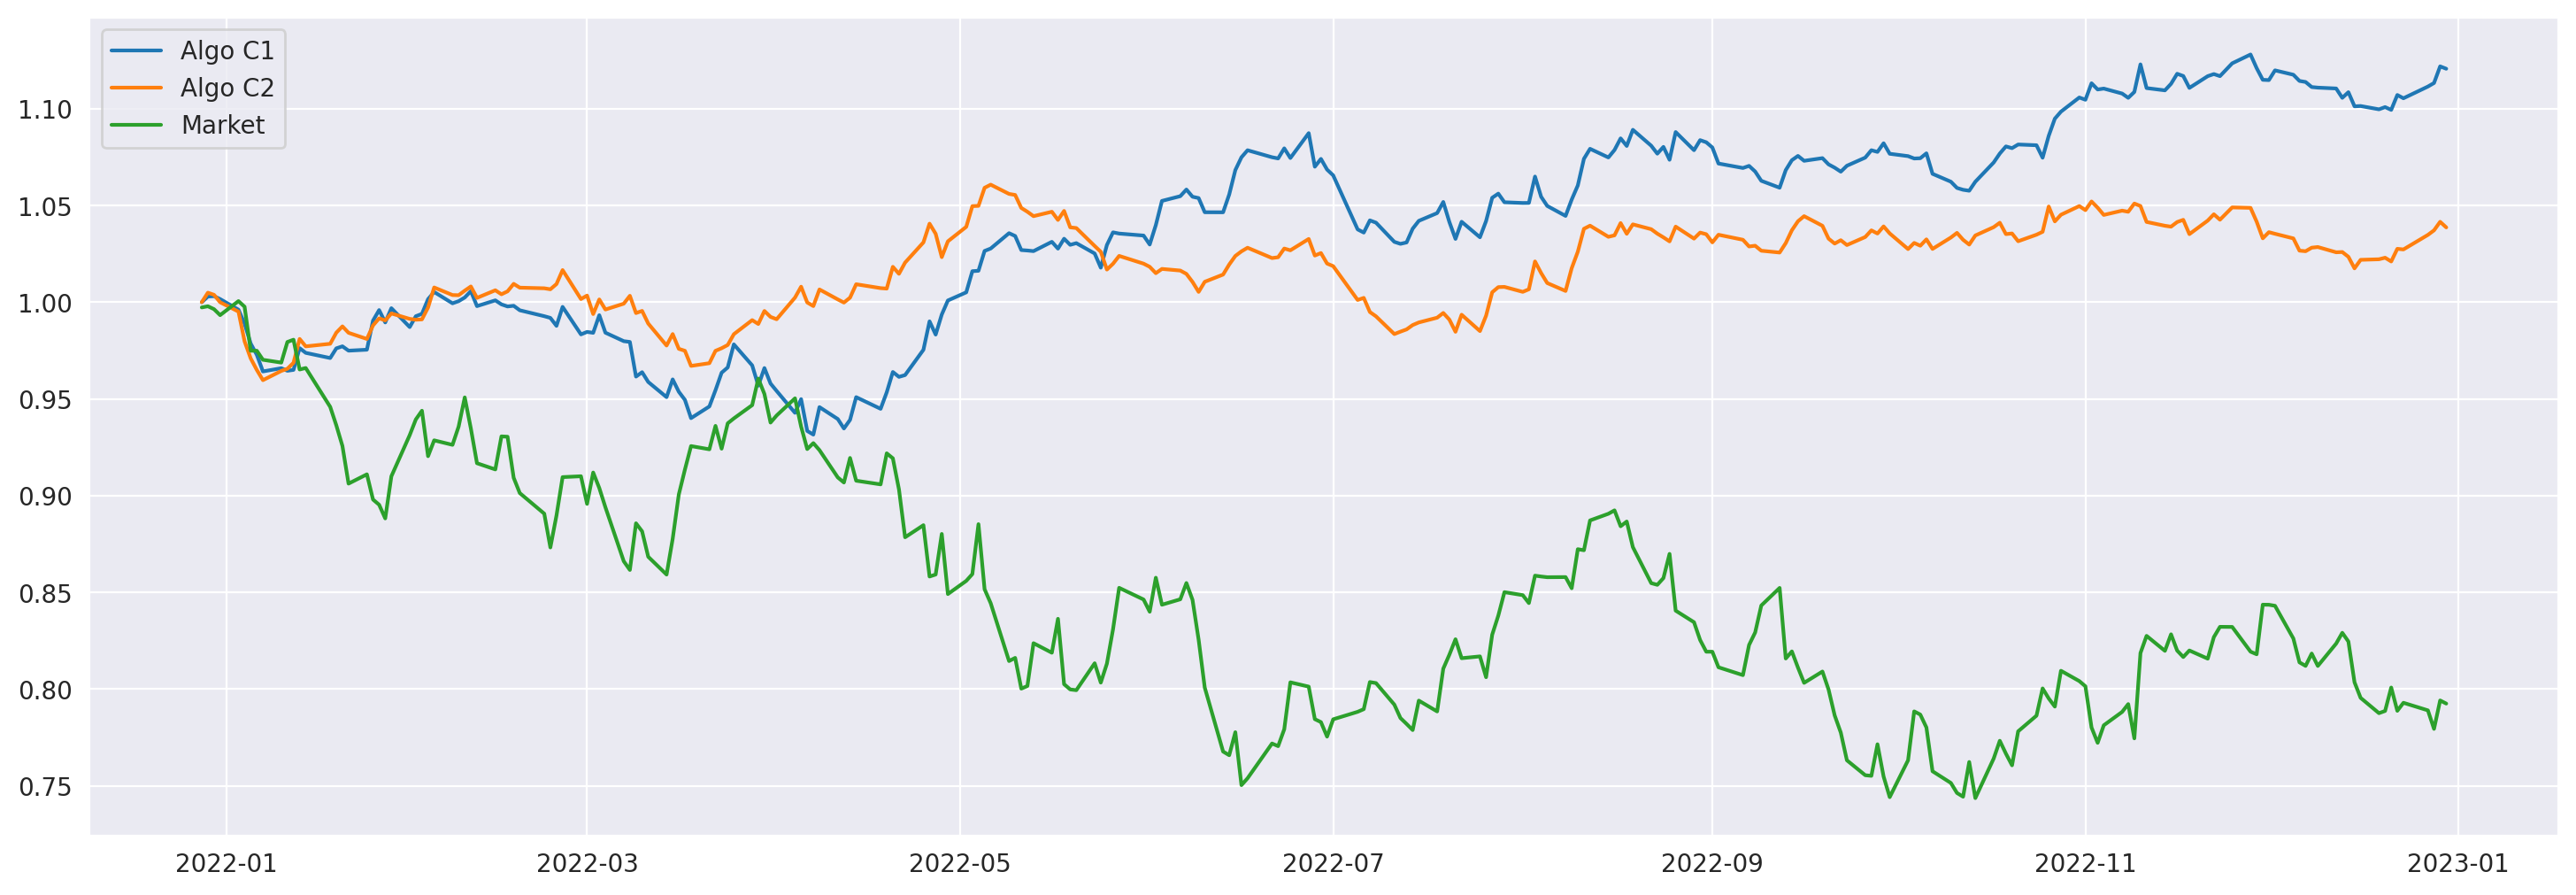

In [57]:
plt.figure(figsize=(18,6))
plt.plot(cumret_c1, label='Algo C1')
plt.plot(cumret_c2, label='Algo C2')
plt.plot(cumret_market, label='Market')
plt.legend()

### Levy area

In [58]:
def backtest_levy(t):
    # prepare data
    returns_tmp = returns.loc[:t].iloc[-w:].dropna(axis=1)
    returns_tmp = returns_tmp.drop('Mkt', axis=1) # remove market returns

    # construct matrix C
    la_matrix = pd.DataFrame(index=returns_tmp.columns, columns=returns_tmp.columns)
    for s1 in la_matrix.index:
        for s2 in la_matrix.columns:
            if s1!=s2 and np.isnan(la_matrix.loc[s1][s2]):
                signatures = ts.stream2sig(returns_tmp[[s1,s2]].values, 2)
                la = 1/2 * (signatures[4] - signatures[5]) # Levy area
                la_matrix.loc[s1][s2] = la
                la_matrix.loc[s2][s1] = -la
    la_matrix = la_matrix.astype(float)
    # define leaders and followers
    leaders = la_matrix.mean(axis=1).sort_values().iloc[-num_leaders:].index
    followers = la_matrix.mean(axis=1).sort_values().iloc[:num_followers].index

    # construct positions dataframe
    positions = pd.DataFrame(index=returns_tmp.iloc[-1:].index, columns=returns.columns)
    if returns_tmp.loc[t][leaders].mean()>=0:
        positions.loc[t, followers] = 1 # long position in followers
        positions.loc[t, ['Mkt']] = -len(followers) # short position in the market
    else:
        positions.loc[t, followers] = -1 # short position in followers
        positions.loc[t, ['Mkt']] = len(followers) # long position in the market

    return positions, la_matrix

In [59]:
e = ProcessPoolExecutor()
futures = [e.submit(backtest_levy, t) for t in prices.iloc[w:].index]
positions = pd.concat([f.result()[0] for f in futures])

In [60]:
# make absolute values of long and short positions sum to 1
positions[positions>0] *= 1/abs(positions[positions>0].sum(axis=1)).values.reshape(-1,1)
positions[positions<0] *= 1/abs(positions[positions<0].sum(axis=1)).values.reshape(-1,1)

In [61]:
# calculate strategy returns
ret = (positions.shift() * returns.loc[positions.index]).sum(axis=1)
cumret_levy = (1 + ret).cumprod()

In [62]:
results_df.loc['Algo Levy'] = calculate_metrics(cumret_levy)

In [63]:
results_df

,Total return,APR,Sharpe,Sortino,MaxDD,MaxDDD
Market,-0.205318,-0.203167,-0.778908,-1.252009,-0.256740,250.0
Algo C1,0.120655,0.119154,1.129044,1.780997,-0.073737,55.0
Algo C2,0.038647,0.038184,0.483870,0.796628,-0.072797,164.0
Algo Levy,0.156170,0.154198,1.323544,2.031958,-0.090052,117.0


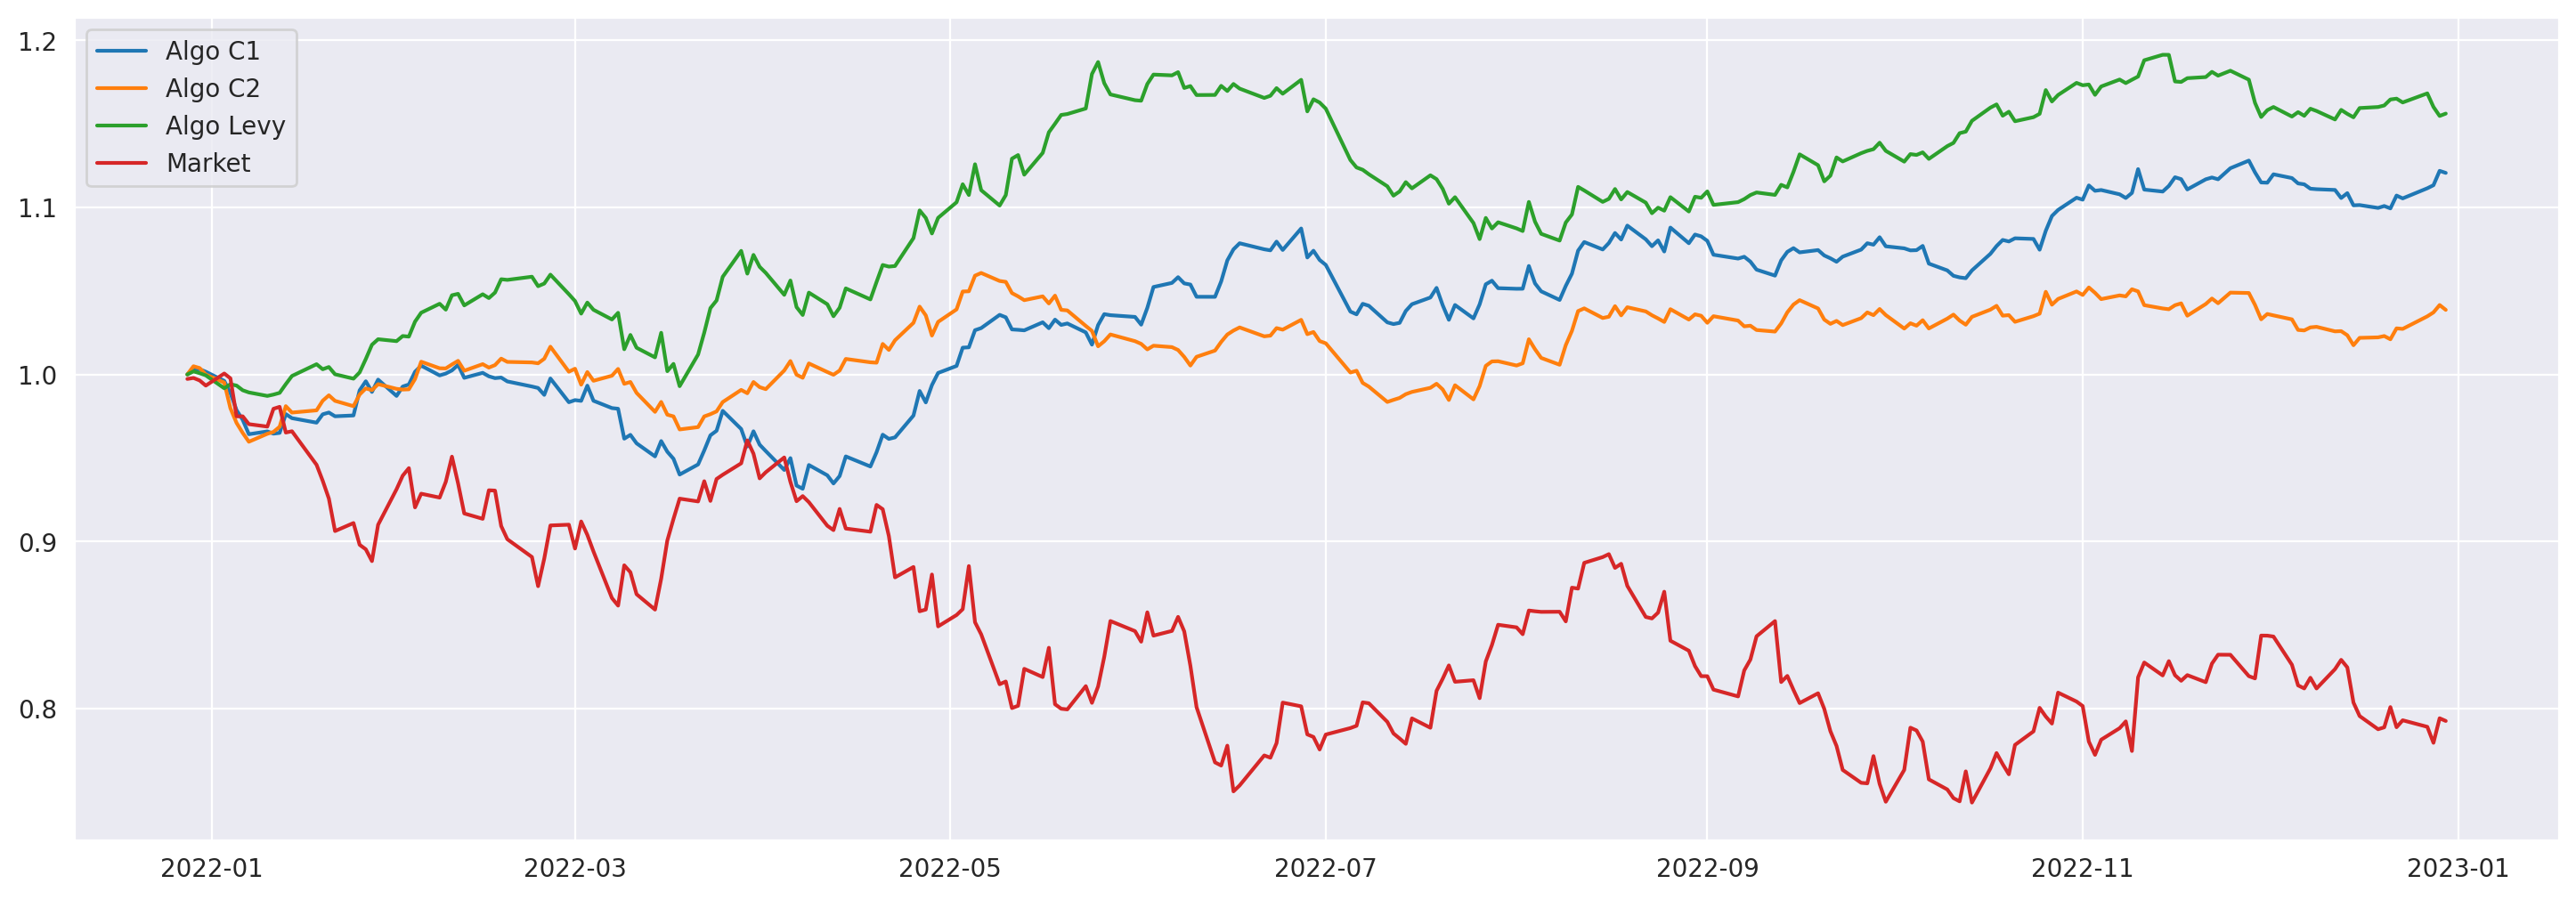

In [64]:
plt.figure(figsize=(18,6))
plt.plot(cumret_c1, label='Algo C1')
plt.plot(cumret_c2, label='Algo C2')
plt.plot(cumret_levy, label='Algo Levy')
plt.plot(cumret_market, label='Market')
plt.legend()